In [1]:
import torch
import torch.nn.functional as F
from torch.optim import lr_scheduler
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [5]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [4]:
#https://torchmetrics.readthedocs.io/en/stable/classification/dice.html
def calc_dice_score(predictions, targets, smooth=1e-5):
    predictions = F.sigmoid(predictions)       
        
    #flatten label and prediction tensors
    predictions = predictions.view(-1)
    targets = targets.view(-1)
        
    intersection = (predictions * targets).sum()                            
    dice_score = (2.*intersection + smooth)/(predictions.sum() + targets.sum() + smooth)
    return dice_score.item()

In [3]:
#https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html#torchmetrics.classification.BinaryJaccardIndex
def calc_iou(predictions, targets, threshold=0.5, smooth=1e-5):

    predictions_sigmoid = torch.sigmoid(predictions)
    predictions_binary = (predictions_sigmoid > threshold).float()
    
    predictions_binary = predictions_binary.view(-1)
    targets = targets.view(-1)

    intersection = (predictions_binary * targets).sum()
    union = predictions_binary.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

In [6]:
# Training params
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 0.001

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = "imagenet"

# Create the model
model = smp.Unet(
    encoder_name= ENCODER_NAME,           # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights= ENCODER_WEIGHTS,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                        # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                            # model output channels (number of classes in your dataset)
    )

# Define loss function
criterion = DiceBCELoss()  # Binary dice Loss for binary segmentation

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
#Scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

run_name = "MODEL-" + model.__class__.__name__ + \
            "-BACKBONE-" + ENCODER_NAME +\
            "-BATCH_SIZE-" + str(BATCH_SIZE) + \
            "-EPOCHS-" + str(EPOCHS) + \
            "-OPTIMIZER-" + optimizer.__class__.__name__ + \
            "-LEARNRATE-" + str(LEARNING_RATE)


# Proper directories
TRAIN_DATA_DIR = 'C:/Users/nicklas/Desktop/dm_unet-main/dm_unet-main/image_data/train'
VAL_DATA_DIR = 'C:/Users/nicklas/Desktop/dm_unet-main/dm_unet-main/image_data/val'

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform = None, target_size = (992, 416)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        self.image_folder = os.path.join(root_dir, 'images')
        self.mask_folder = os.path.join(root_dir, 'masks')

        self.images = os.listdir(self.image_folder)
        self.masks = os.listdir(self.mask_folder)

        assert len(self.images) == len(self.masks), "Number of images and masks should be the same."

        self.imageConverter = transforms.Compose([transforms.PILToTensor()])
        self.maskConverter = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return 40

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.images[idx])
        if "patient" in self.images[idx]:
            mask_path = os.path.join(self.mask_folder, "segmentation_" + self.images[idx][-7:])
        else:
            mask_path = os.path.join(self.mask_folder, "target_seg_" + self.images[idx][-7:])

        # Load images
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')

        # Convert to tensors
        tensor_image = self.imageConverter(image)
        tensor_mask = self.maskConverter(mask)
        tensor_mask = tensor_mask[2:, :, :]

        # add padding
        pad_height = max(self.target_size[0] - tensor_image.size(1), 0)
        pad_width = max(self.target_size[1] - tensor_image.size(2), 0)

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_image = transforms.functional.pad(tensor_image, (pad_left, pad_bottom, pad_right, pad_top), fill=255)
        padded_mask = transforms.functional.pad(tensor_mask, (pad_left, pad_bottom, pad_right, pad_top), fill=0)

        if self.transform:
            padded_image = self.transform(padded_image)
            padded_mask = self.transform(padded_mask)

        return torch.tensor(padded_image, dtype=torch.float32), torch.tensor(padded_mask, dtype=torch.float32)


In [8]:

model = model.to(device)

# Set up dataset and dataloader
transform = transforms.Compose([])

trainDataset = SegmentationDataset(root_dir=TRAIN_DATA_DIR, transform=transform)
valDataset = SegmentationDataset(root_dir=VAL_DATA_DIR, transform=transform)

train_loader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [36]:

# Train Loop
for epoch in range(EPOCHS):
    model.train()

    # Use tqdm to add a progress bar
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}', leave=False):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        # outputs = torch.argmax(outputs, dim=1).unsqueeze(1).float()

        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        print(loss.detach().item())
        optimizer.step()

    # Validation
    model.eval()

    val_loss = 0.0
    iou = 0.0
    dice_score = 0.0
    

    with torch.no_grad():
        for val_images, val_masks in tqdm(val_loader, desc=f'Validation', leave=False):
            val_images, val_masks = val_images.to(device), val_masks.to(device)

            model_outputs = model(val_images)

            val_loss += criterion(model_outputs, val_masks).item()
            
            dice_score += calc_dice_score(model_outputs, val_masks)
            
            iou += calc_iou(model_outputs, val_masks)


    val_loss /= len(val_loader)
    iou /= len(val_loader)
    dice_score /= len(val_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {loss.item()}, Validation Loss: {val_loss}\n"
          f"IOU: {iou}, Dice Score: {dice_score}")

# Save the trained model
torch.save(model.state_dict(), run_name + '.pth')


Epoch 1/10:   0%|                                                                               | 0/10 [00:00<?, ?it/s]<ipython-input-30-2f10b68d7173>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(padded_image, dtype=torch.float32), torch.tensor(padded_mask, dtype=torch.float32)
Epoch 1/10:  10%|███████                                                                | 1/10 [00:08<01:15,  8.43s/it]

1.1612367630004883


Epoch 1/10:  20%|██████████████▏                                                        | 2/10 [00:17<01:08,  8.62s/it]

1.154354214668274


Epoch 1/10:  30%|█████████████████████▎                                                 | 3/10 [00:25<00:59,  8.57s/it]

1.154099702835083


Epoch 1/10:  40%|████████████████████████████▍                                          | 4/10 [00:34<00:51,  8.57s/it]

1.1443188190460205


Epoch 1/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:42<00:43,  8.60s/it]

1.1416093111038208


Epoch 1/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:51<00:34,  8.67s/it]

1.1356804370880127


Epoch 1/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:00<00:25,  8.65s/it]

1.1325788497924805


Epoch 1/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:08<00:17,  8.59s/it]

1.1261805295944214


Epoch 1/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:17<00:08,  8.53s/it]

1.122727632522583


1.1175155639648438


Epoch [1/10], Train Loss: 1.1175155639648438, Validation Loss: 2.1286887407302855
IOU: 9.354315169685101e-11, Dice Score: 3.7721030465842634e-11


Epoch 2/10:  10%|███████                                                                | 1/10 [00:08<01:19,  8.86s/it]

1.1144033670425415


Epoch 2/10:  20%|██████████████▏                                                        | 2/10 [00:17<01:08,  8.57s/it]

1.1148711442947388


Epoch 2/10:  30%|█████████████████████▎                                                 | 3/10 [00:25<00:59,  8.56s/it]

1.108565092086792


Epoch 2/10:  40%|████████████████████████████▍                                          | 4/10 [00:34<00:51,  8.63s/it]

1.105353593826294


Epoch 2/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:43<00:43,  8.68s/it]

1.1021668910980225


Epoch 2/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:52<00:34,  8.72s/it]

1.099350929260254


Epoch 2/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:00<00:26,  8.78s/it]

1.0942925214767456


Epoch 2/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:10<00:17,  8.88s/it]

1.0908687114715576


Epoch 2/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:18<00:08,  8.89s/it]

1.0887409448623657


1.0853259563446045


Epoch [2/10], Train Loss: 1.0853259563446045, Validation Loss: 1.1115532875061036
IOU: 1.7246273076310104e-09, Dice Score: 5.955405092683552e-11


Epoch 3/10:  10%|███████                                                                | 1/10 [00:09<01:21,  9.00s/it]

1.0827796459197998


Epoch 3/10:  20%|██████████████▏                                                        | 2/10 [00:17<01:11,  8.98s/it]

1.0802561044692993


Epoch 3/10:  30%|█████████████████████▎                                                 | 3/10 [00:26<01:02,  8.88s/it]

1.0786216259002686


Epoch 3/10:  40%|████████████████████████████▍                                          | 4/10 [00:35<00:53,  8.96s/it]

1.0769765377044678


Epoch 3/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:44<00:44,  8.82s/it]

1.0745466947555542


Epoch 3/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:53<00:35,  8.75s/it]

1.0726302862167358


Epoch 3/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:01<00:26,  8.74s/it]

1.0705784559249878


Epoch 3/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:10<00:17,  8.60s/it]

1.0691312551498413


Epoch 3/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:18<00:08,  8.60s/it]

1.0670225620269775


1.066127061843872


Epoch [3/10], Train Loss: 1.066127061843872, Validation Loss: 1.0695265412330628
IOU: 3.410692874794563e-08, Dice Score: 9.063334249770349e-11


Epoch 4/10:  10%|███████                                                                | 1/10 [00:08<01:15,  8.36s/it]

1.063007116317749


Epoch 4/10:  20%|██████████████▏                                                        | 2/10 [00:16<01:06,  8.31s/it]

1.0623902082443237


Epoch 4/10:  30%|█████████████████████▎                                                 | 3/10 [00:24<00:58,  8.30s/it]

1.0605840682983398


Epoch 4/10:  40%|████████████████████████████▍                                          | 4/10 [00:33<00:49,  8.31s/it]

1.0589529275894165


Epoch 4/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:41<00:42,  8.43s/it]

1.057548999786377


Epoch 4/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:50<00:33,  8.47s/it]

1.0564000606536865


Epoch 4/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [00:58<00:25,  8.49s/it]

1.0547598600387573


Epoch 4/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:07<00:16,  8.46s/it]

1.05336332321167


Epoch 4/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:15<00:08,  8.41s/it]

1.0520604848861694


1.0510015487670898


Epoch [4/10], Train Loss: 1.0510015487670898, Validation Loss: 1.0553418040275573
IOU: 0.5000010107111053, Dice Score: 1.1278619704846449e-10


Epoch 5/10:  10%|███████                                                                | 1/10 [00:08<01:20,  8.90s/it]

1.0500819683074951


Epoch 5/10:  20%|██████████████▏                                                        | 2/10 [00:17<01:09,  8.66s/it]

1.0491161346435547


Epoch 5/10:  30%|█████████████████████▎                                                 | 3/10 [00:25<00:59,  8.51s/it]

1.0478543043136597


Epoch 5/10:  40%|████████████████████████████▍                                          | 4/10 [00:34<00:50,  8.50s/it]

1.047357439994812


Epoch 5/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:42<00:42,  8.55s/it]

1.0459457635879517


Epoch 5/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:51<00:34,  8.63s/it]

1.045979619026184


Epoch 5/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [00:59<00:25,  8.54s/it]

1.04428231716156


Epoch 5/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:08<00:16,  8.48s/it]

1.0438302755355835


Epoch 5/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:16<00:08,  8.47s/it]

1.0424691438674927


1.0413093566894531


Epoch [5/10], Train Loss: 1.0413093566894531, Validation Loss: 1.045169711112976
IOU: 1.0, Dice Score: 1.3740480142576673e-10


Epoch 6/10:  10%|███████                                                                | 1/10 [00:09<01:21,  9.08s/it]

1.0405429601669312


Epoch 6/10:  20%|██████████████▏                                                        | 2/10 [00:18<01:15,  9.50s/it]

1.0397971868515015


Epoch 6/10:  30%|█████████████████████▎                                                 | 3/10 [00:28<01:05,  9.36s/it]

1.0393364429473877


Epoch 6/10:  40%|████████████████████████████▍                                          | 4/10 [00:37<00:55,  9.20s/it]

1.0383281707763672


Epoch 6/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:45<00:45,  9.10s/it]

1.0376129150390625


Epoch 6/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:55<00:37,  9.31s/it]

1.0374138355255127


Epoch 6/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:04<00:27,  9.30s/it]

1.0362164974212646


Epoch 6/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:14<00:18,  9.23s/it]

1.0356088876724243


Epoch 6/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:22<00:09,  9.14s/it]

1.0350168943405151


1.0341840982437134


Epoch [6/10], Train Loss: 1.0341840982437134, Validation Loss: 1.0374054312705994
IOU: 1.0, Dice Score: 1.652362732751378e-10


Epoch 7/10:  10%|███████                                                                | 1/10 [00:09<01:24,  9.36s/it]

1.0338186025619507


Epoch 7/10:  20%|██████████████▏                                                        | 2/10 [00:18<01:15,  9.46s/it]

1.033279538154602


Epoch 7/10:  30%|█████████████████████▎                                                 | 3/10 [00:27<01:04,  9.16s/it]

1.0324939489364624


Epoch 7/10:  40%|████████████████████████████▍                                          | 4/10 [00:36<00:54,  9.06s/it]

1.0320024490356445


Epoch 7/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:45<00:45,  9.03s/it]

1.031908392906189


Epoch 7/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:54<00:36,  9.05s/it]

1.0309642553329468


Epoch 7/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:03<00:27,  9.04s/it]

1.0303840637207031


Epoch 7/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:12<00:17,  8.95s/it]

1.0299888849258423


Epoch 7/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:21<00:08,  8.97s/it]

1.0295363664627075


1.028875470161438


Epoch [7/10], Train Loss: 1.028875470161438, Validation Loss: 1.030830156803131
IOU: 0.9000009999899703, Dice Score: 1.9969130932162572e-10


Epoch 8/10:  10%|███████                                                                | 1/10 [00:09<01:21,  9.00s/it]

1.0287708044052124


Epoch 8/10:  20%|██████████████▏                                                        | 2/10 [00:17<01:10,  8.80s/it]

1.0280464887619019


Epoch 8/10:  30%|█████████████████████▎                                                 | 3/10 [00:26<01:01,  8.72s/it]

1.0276721715927124


Epoch 8/10:  40%|████████████████████████████▍                                          | 4/10 [00:35<00:53,  8.86s/it]

1.0271682739257812


Epoch 8/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:44<00:44,  8.81s/it]

1.026856780052185


Epoch 8/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:52<00:35,  8.84s/it]

1.026713490486145


Epoch 8/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:01<00:25,  8.65s/it]

1.0260140895843506


Epoch 8/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:10<00:17,  8.82s/it]

1.0255571603775024


Epoch 8/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:19<00:09,  9.01s/it]

1.0251466035842896


1.025450348854065


Epoch [8/10], Train Loss: 1.025450348854065, Validation Loss: 1.0259185671806335
IOU: 0.8000010833232352, Dice Score: 2.368496149207644e-10


Epoch 9/10:  10%|███████                                                                | 1/10 [00:09<01:23,  9.27s/it]

1.0244061946868896


Epoch 9/10:  20%|██████████████▏                                                        | 2/10 [00:18<01:14,  9.31s/it]

1.024033546447754


Epoch 9/10:  30%|█████████████████████▎                                                 | 3/10 [00:28<01:05,  9.37s/it]

1.0237505435943604


Epoch 9/10:  40%|████████████████████████████▍                                          | 4/10 [00:37<00:57,  9.58s/it]

1.023881435394287


Epoch 9/10:  50%|███████████████████████████████████▌                                   | 5/10 [00:47<00:47,  9.57s/it]

1.0238152742385864


Epoch 9/10:  60%|██████████████████████████████████████████▌                            | 6/10 [00:56<00:37,  9.45s/it]

1.023115873336792


Epoch 9/10:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:05<00:28,  9.36s/it]

1.0226033926010132


Epoch 9/10:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:15<00:18,  9.44s/it]

1.0222890377044678


Epoch 9/10:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [01:24<00:09,  9.21s/it]

1.0219027996063232


1.0215336084365845


Epoch [9/10], Train Loss: 1.0215336084365845, Validation Loss: 1.0218010306358338
IOU: 0.500000102012146, Dice Score: 2.810418370247092e-10


Epoch 10/10:  10%|███████                                                               | 1/10 [00:08<01:18,  8.77s/it]

1.0212875604629517


Epoch 10/10:  20%|██████████████                                                        | 2/10 [00:17<01:09,  8.72s/it]

1.02106511592865


Epoch 10/10:  30%|█████████████████████                                                 | 3/10 [00:26<01:02,  9.00s/it]

1.0208936929702759


Epoch 10/10:  40%|████████████████████████████                                          | 4/10 [00:35<00:54,  9.08s/it]

1.020452857017517


Epoch 10/10:  50%|███████████████████████████████████                                   | 5/10 [00:45<00:45,  9.19s/it]

1.0202186107635498


Epoch 10/10:  60%|██████████████████████████████████████████                            | 6/10 [00:54<00:36,  9.10s/it]

1.0198827981948853


Epoch 10/10:  70%|█████████████████████████████████████████████████                     | 7/10 [01:02<00:26,  8.90s/it]

1.019685983657837


Epoch 10/10:  80%|████████████████████████████████████████████████████████              | 8/10 [01:11<00:17,  8.82s/it]

1.0193740129470825


Epoch 10/10:  90%|███████████████████████████████████████████████████████████████       | 9/10 [01:20<00:08,  8.77s/it]

1.0191848278045654


1.0193588733673096


Epoch [10/10], Train Loss: 1.0193588733673096, Validation Loss: 1.019298529624939
IOU: 0.9000001111109895, Dice Score: 3.167106021884081e-10


In [9]:

def plot_image_mask_prediction(image, mask, predicted_mask, title="Image, Ground Truth, and Predicted Mask"):

    # Convert PyTorch tensors to NumPy arrays if needed
    image = image.squeeze(dim=0)
    image = image.detach().numpy()
    mask = mask.squeeze(dim=0)
    mask = mask.detach().numpy()
    predicted_mask = predicted_mask.squeeze(dim=0)
    predicted_mask = predicted_mask.detach().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot the ground truth mask
    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Plot the predicted mask
    axes[2].imshow(predicted_mask.squeeze(), cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    # Set the title for the entire plot
    plt.suptitle(title)

    # Show the plot
    plt.show()

<ipython-input-7-2f10b68d7173>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(padded_image, dtype=torch.float32), torch.tensor(padded_mask, dtype=torch.float32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


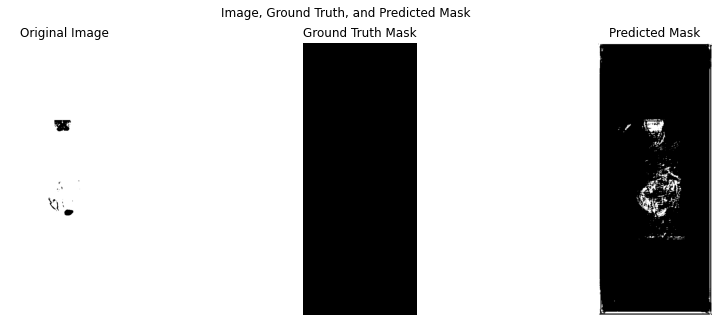

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


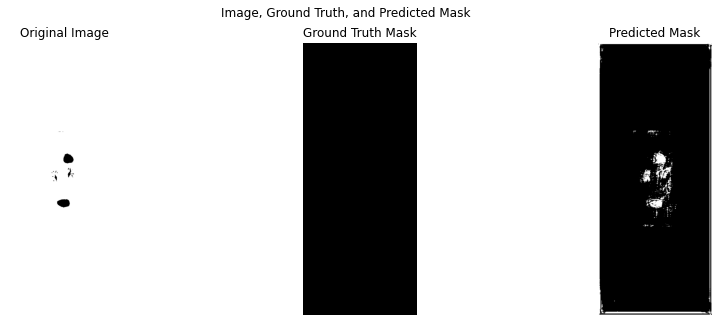

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


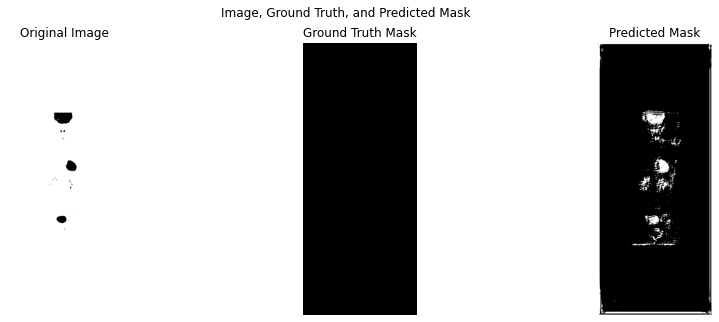

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


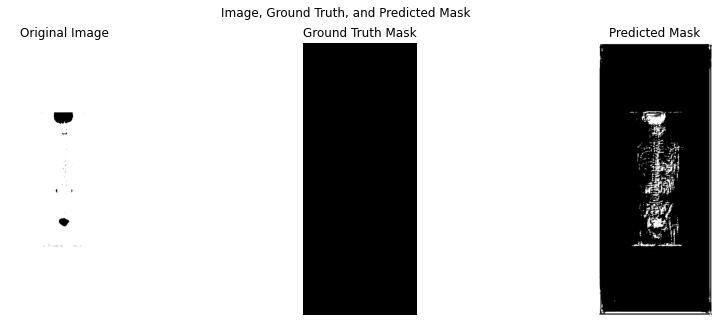

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


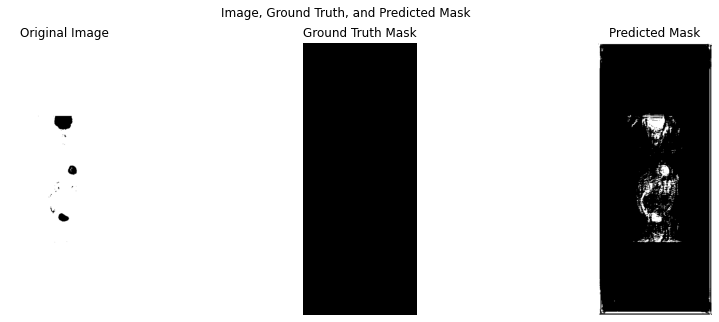

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


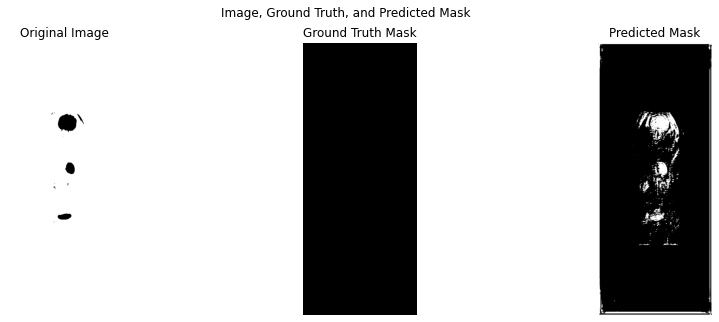

In [11]:
model = 

test_loader = DataLoader(valDataset, batch_size= 1 , shuffle=False, num_workers=0)
n = 5
count = 0 
for images, masks in test_loader:
    model.eval()
    model_outputs = model(images)
    predictions_sigmoid = torch.sigmoid(model_outputs)
    predictions_binary = (predictions_sigmoid > 0.5).float()
    plot_image_mask_prediction(images, masks, predicted_mask=predictions_binary)  
    
    if count == 5: 
        break
    count += 1

